In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_voting'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 818.46it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:18<00:00, 15.16img/s]

***
Unet Loss: 0.49405819177627563     Segnet Loss: 0.7341654300689697     Enet Loss: 1.1384985446929932
Voting Loss: 0.7889073888460795


Epoch 1/50:  99%|█████████▊| 200/203 [00:22<00:00,  8.86img/s]

---
Unet Validation Dice Score: 0.38285279273986816     Segnet Validation Dice Score: 0.04132740944623947     Enet Validation Dice Score: 0.2231769859790802
---
Ensemble Voting Validation Dice Loss: 1.054758628209432
Ensemble Voting Validation Pixel Accuracy: 0.8383283113178454 
Ensemble Voting Validation MIoU: 0.5774028881224228
Ensemble Voting Validation Dice Score: 0.5257811546325684 



Epoch 2/50:  99%|█████████▊| 200/203 [00:16<00:00, 15.19img/s]

***
Unet Loss: 0.4080093502998352     Segnet Loss: 0.4243001341819763     Enet Loss: 1.0562264919281006
Voting Loss: 0.6295119921366373


Epoch 2/50:  99%|█████████▊| 200/203 [00:21<00:00,  9.52img/s]

---
Unet Validation Dice Score: 0.7108675241470337     Segnet Validation Dice Score: 0.5355493426322937     Enet Validation Dice Score: 0.26512882113456726
---
Ensemble Voting Validation Dice Loss: 0.7109514872233073
Ensemble Voting Validation Pixel Accuracy: 0.9265479372258771 
Ensemble Voting Validation MIoU: 0.7642637643451162
Ensemble Voting Validation Dice Score: 0.72959965467453 



Epoch 3/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.16img/s]

***
Unet Loss: 0.3317459225654602     Segnet Loss: 0.282243013381958     Enet Loss: 0.9533968567848206
Voting Loss: 0.5224619309107462


Epoch 3/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.67img/s]

---
Unet Validation Dice Score: 0.8366488814353943     Segnet Validation Dice Score: 0.7976505160331726     Enet Validation Dice Score: 0.32018911838531494
---
Ensemble Voting Validation Dice Loss: 0.5409127473831177
Ensemble Voting Validation Pixel Accuracy: 0.9424015513637609 
Ensemble Voting Validation MIoU: 0.8099961109472191
Ensemble Voting Validation Dice Score: 0.8240371942520142 



Epoch 4/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.18img/s]

***
Unet Loss: 0.3030807077884674     Segnet Loss: 0.22186912596225739     Enet Loss: 0.8915606141090393
Voting Loss: 0.472170149286588


Epoch 4/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.02img/s]

---
Unet Validation Dice Score: 0.8074266314506531     Segnet Validation Dice Score: 0.8340921401977539     Enet Validation Dice Score: 0.3831530213356018
---
Ensemble Voting Validation Dice Loss: 0.49570727348327637
Ensemble Voting Validation Pixel Accuracy: 0.9425854599266722 
Ensemble Voting Validation MIoU: 0.8156142001244908
Ensemble Voting Validation Dice Score: 0.8443546295166016 



Epoch 5/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.13img/s]

***
Unet Loss: 0.3694829046726227     Segnet Loss: 0.23718076944351196     Enet Loss: 0.803680419921875
Voting Loss: 0.47011469801266986


Epoch 5/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.07img/s]

---
Unet Validation Dice Score: 0.8125753402709961     Segnet Validation Dice Score: 0.829002857208252     Enet Validation Dice Score: 0.4529034197330475
---
Ensemble Voting Validation Dice Loss: 0.5091539621353149
Ensemble Voting Validation Pixel Accuracy: 0.9378980670058936 
Ensemble Voting Validation MIoU: 0.8097474526849249
Ensemble Voting Validation Dice Score: 0.8379087448120117 



Epoch 6/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
Unet Loss: 0.2216491997241974     Segnet Loss: 0.15609371662139893     Enet Loss: 0.7357066869735718
Voting Loss: 0.37114986777305603


Epoch 6/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.01img/s]

---
Unet Validation Dice Score: 0.8757835626602173     Segnet Validation Dice Score: 0.8494479060173035     Enet Validation Dice Score: 0.5190005302429199
---
Ensemble Voting Validation Dice Loss: 0.41505205631256104
Ensemble Voting Validation Pixel Accuracy: 0.9516767535293311 
Ensemble Voting Validation MIoU: 0.8414608511864621
Ensemble Voting Validation Dice Score: 0.864859402179718 



Epoch 7/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
Unet Loss: 0.24018830060958862     Segnet Loss: 0.1387837827205658     Enet Loss: 0.6835072040557861
Voting Loss: 0.35415976246198017


Epoch 7/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.13img/s]

---
Unet Validation Dice Score: 0.8549639582633972     Segnet Validation Dice Score: 0.8521418571472168     Enet Validation Dice Score: 0.5735542178153992
---
Ensemble Voting Validation Dice Loss: 0.39500681559244794
Ensemble Voting Validation Pixel Accuracy: 0.9476163094503838 
Ensemble Voting Validation MIoU: 0.8287503053022236
Ensemble Voting Validation Dice Score: 0.8582664728164673 



Epoch 8/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.2547961473464966     Segnet Loss: 0.16836673021316528     Enet Loss: 0.6241322755813599
Voting Loss: 0.3490983843803406


Epoch 8/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.15img/s]

---
Unet Validation Dice Score: 0.82227623462677     Segnet Validation Dice Score: 0.8657659888267517     Enet Validation Dice Score: 0.6251208186149597
---
Ensemble Voting Validation Dice Loss: 0.38346993923187256
Ensemble Voting Validation Pixel Accuracy: 0.946853102299205 
Ensemble Voting Validation MIoU: 0.8265175702375297
Ensemble Voting Validation Dice Score: 0.8729622960090637 



Epoch 9/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
Unet Loss: 0.21588176488876343     Segnet Loss: 0.17143256962299347     Enet Loss: 0.5971776247024536
Voting Loss: 0.3281639864047368


Epoch 9/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.15img/s]

---
Unet Validation Dice Score: 0.8626108169555664     Segnet Validation Dice Score: 0.8320901989936829     Enet Validation Dice Score: 0.6667215824127197
---
Ensemble Voting Validation Dice Loss: 0.3423854509989421
Ensemble Voting Validation Pixel Accuracy: 0.9583999901487116 
Ensemble Voting Validation MIoU: 0.8585487791114108
Ensemble Voting Validation Dice Score: 0.8573627471923828 



Epoch 10/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.19642961025238037     Segnet Loss: 0.11827673017978668     Enet Loss: 0.5467969179153442
Voting Loss: 0.2871677527825038


Epoch 10/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.18img/s]

---
Unet Validation Dice Score: 0.8943592309951782     Segnet Validation Dice Score: 0.8731061220169067     Enet Validation Dice Score: 0.7025718092918396
---
Ensemble Voting Validation Dice Loss: 0.33220722277959186
Ensemble Voting Validation Pixel Accuracy: 0.9539893970154879 
Ensemble Voting Validation MIoU: 0.8469155218249549
Ensemble Voting Validation Dice Score: 0.8872235417366028 



Epoch 11/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
Unet Loss: 0.2316317856311798     Segnet Loss: 0.1479145735502243     Enet Loss: 0.5429143905639648
Voting Loss: 0.30748691658178967


Epoch 11/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.23img/s]

---
Unet Validation Dice Score: 0.9009869694709778     Segnet Validation Dice Score: 0.884381115436554     Enet Validation Dice Score: 0.7315632104873657
---
Ensemble Voting Validation Dice Loss: 0.3063194751739502
Ensemble Voting Validation Pixel Accuracy: 0.9588810435512609 
Ensemble Voting Validation MIoU: 0.8588695930291661
Ensemble Voting Validation Dice Score: 0.894659698009491 



Epoch 12/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
Unet Loss: 0.1839371919631958     Segnet Loss: 0.14799192547798157     Enet Loss: 0.4766201376914978
Voting Loss: 0.2695164183775584


Epoch 12/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.08img/s]

---
Unet Validation Dice Score: 0.9023966789245605     Segnet Validation Dice Score: 0.8296767473220825     Enet Validation Dice Score: 0.7552794814109802
---
Ensemble Voting Validation Dice Loss: 0.3431670665740967
Ensemble Voting Validation Pixel Accuracy: 0.9513860334429824 
Ensemble Voting Validation MIoU: 0.8354086880412157
Ensemble Voting Validation Dice Score: 0.8993880152702332 



Epoch 13/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
Unet Loss: 0.173979252576828     Segnet Loss: 0.09254009276628494     Enet Loss: 0.4498319923877716
Voting Loss: 0.23878377924362817


Epoch 13/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.04img/s]

---
Unet Validation Dice Score: 0.8966676592826843     Segnet Validation Dice Score: 0.8787361979484558     Enet Validation Dice Score: 0.7734567523002625
---
Ensemble Voting Validation Dice Loss: 0.2790611982345581
Ensemble Voting Validation Pixel Accuracy: 0.9633098401521382 
Ensemble Voting Validation MIoU: 0.8731674921782107
Ensemble Voting Validation Dice Score: 0.8876779675483704 



Epoch 14/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
Unet Loss: 0.17236140370368958     Segnet Loss: 0.1408836841583252     Enet Loss: 0.3913559913635254
Voting Loss: 0.2348670264085134


Epoch 14/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.07img/s]

---
Unet Validation Dice Score: 0.903175950050354     Segnet Validation Dice Score: 0.8920686841011047     Enet Validation Dice Score: 0.788504958152771
---
Ensemble Voting Validation Dice Loss: 0.26992019017537433
Ensemble Voting Validation Pixel Accuracy: 0.9625993695175439 
Ensemble Voting Validation MIoU: 0.8721934509821963
Ensemble Voting Validation Dice Score: 0.8970465660095215 



Epoch 15/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
Unet Loss: 0.17717260122299194     Segnet Loss: 0.11215916275978088     Enet Loss: 0.41742950677871704
Voting Loss: 0.23558709025382996


Epoch 15/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.02img/s]

---
Unet Validation Dice Score: 0.8987926840782166     Segnet Validation Dice Score: 0.882002055644989     Enet Validation Dice Score: 0.8016197085380554
---
Ensemble Voting Validation Dice Loss: 0.2764381965001424
Ensemble Voting Validation Pixel Accuracy: 0.9573356226870888 
Ensemble Voting Validation MIoU: 0.8571756416452058
Ensemble Voting Validation Dice Score: 0.897005558013916 



Epoch 16/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
Unet Loss: 0.16411423683166504     Segnet Loss: 0.06723054498434067     Enet Loss: 0.3397161364555359
Voting Loss: 0.1903536394238472


Epoch 16/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.05img/s]

---
Unet Validation Dice Score: 0.9013206362724304     Segnet Validation Dice Score: 0.8889793753623962     Enet Validation Dice Score: 0.8152174949645996
---
Ensemble Voting Validation Dice Loss: 0.25493045647939044
Ensemble Voting Validation Pixel Accuracy: 0.9615885416666666 
Ensemble Voting Validation MIoU: 0.8698964669248692
Ensemble Voting Validation Dice Score: 0.897567093372345 



Epoch 17/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.06img/s]

***
Unet Loss: 0.14672330021858215     Segnet Loss: 0.08458027988672256     Enet Loss: 0.30259793996810913
Voting Loss: 0.17796717335780463


Epoch 17/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.00img/s]

---
Unet Validation Dice Score: 0.9062946438789368     Segnet Validation Dice Score: 0.8976075053215027     Enet Validation Dice Score: 0.8272656798362732
---
Ensemble Voting Validation Dice Loss: 0.26089731852213544
Ensemble Voting Validation Pixel Accuracy: 0.9586079915364584 
Ensemble Voting Validation MIoU: 0.8610356304326314
Ensemble Voting Validation Dice Score: 0.9058950543403625 



Epoch 18/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
Unet Loss: 0.15879327058792114     Segnet Loss: 0.07787181437015533     Enet Loss: 0.33744561672210693
Voting Loss: 0.19137023389339447


Epoch 18/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.16img/s]

---
Unet Validation Dice Score: 0.9036158919334412     Segnet Validation Dice Score: 0.8841652870178223     Enet Validation Dice Score: 0.8304144144058228
---
Ensemble Voting Validation Dice Loss: 0.2581004500389099
Ensemble Voting Validation Pixel Accuracy: 0.9578525476288378 
Ensemble Voting Validation MIoU: 0.8607701994180854
Ensemble Voting Validation Dice Score: 0.892552375793457 



Epoch 19/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
Unet Loss: 0.17750540375709534     Segnet Loss: 0.08432620018720627     Enet Loss: 0.32692328095436096
Voting Loss: 0.1962516282995542


Epoch 19/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.07img/s]

---
Unet Validation Dice Score: 0.905264675617218     Segnet Validation Dice Score: 0.9022948145866394     Enet Validation Dice Score: 0.8396455645561218
---
Ensemble Voting Validation Dice Loss: 0.2487736940383911
Ensemble Voting Validation Pixel Accuracy: 0.959783721388432 
Ensemble Voting Validation MIoU: 0.865755225038385
Ensemble Voting Validation Dice Score: 0.907284677028656 



Epoch 20/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.80img/s]

***
Unet Loss: 0.15015599131584167     Segnet Loss: 0.07930055260658264     Enet Loss: 0.3299614191055298
Voting Loss: 0.18647265434265137


Epoch 20/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.08img/s]

---
Unet Validation Dice Score: 0.9020659327507019     Segnet Validation Dice Score: 0.8814353346824646     Enet Validation Dice Score: 0.8368661999702454
---
Ensemble Voting Validation Dice Loss: 0.2500353256861369
Ensemble Voting Validation Pixel Accuracy: 0.956240737647341 
Ensemble Voting Validation MIoU: 0.8563624164193034
Ensemble Voting Validation Dice Score: 0.8925711512565613 



Epoch 21/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.12img/s]

***
Unet Loss: 0.16577020287513733     Segnet Loss: 0.07596465200185776     Enet Loss: 0.291913777589798
Voting Loss: 0.17788287748893103


Epoch 21/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.88img/s]

---
Unet Validation Dice Score: 0.9080076217651367     Segnet Validation Dice Score: 0.902739942073822     Enet Validation Dice Score: 0.8427078127861023
---
Ensemble Voting Validation Dice Loss: 0.22368826468785605
Ensemble Voting Validation Pixel Accuracy: 0.964627182274534 
Ensemble Voting Validation MIoU: 0.8773075702617916
Ensemble Voting Validation Dice Score: 0.9094758033752441 



Epoch 22/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.11img/s]

***
Unet Loss: 0.14342457056045532     Segnet Loss: 0.06662608683109283     Enet Loss: 0.2517384886741638
Voting Loss: 0.15392971535523733


Epoch 22/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.04img/s]

---
Unet Validation Dice Score: 0.9082361459732056     Segnet Validation Dice Score: 0.9103002548217773     Enet Validation Dice Score: 0.8517762422561646
---
Ensemble Voting Validation Dice Loss: 0.21600103378295898
Ensemble Voting Validation Pixel Accuracy: 0.9670988384046053 
Ensemble Voting Validation MIoU: 0.8843328292110243
Ensemble Voting Validation Dice Score: 0.9123908281326294 



Epoch 23/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
Unet Loss: 0.1502770185470581     Segnet Loss: 0.06213565915822983     Enet Loss: 0.23717975616455078
Voting Loss: 0.14986414462327957


Epoch 23/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.20img/s]

---
Unet Validation Dice Score: 0.9084120988845825     Segnet Validation Dice Score: 0.9066528677940369     Enet Validation Dice Score: 0.8501297831535339
---
Ensemble Voting Validation Dice Loss: 0.22088356812795004
Ensemble Voting Validation Pixel Accuracy: 0.9657357199150219 
Ensemble Voting Validation MIoU: 0.8811298055459114
Ensemble Voting Validation Dice Score: 0.9097356796264648 



Epoch 24/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
Unet Loss: 0.15979403257369995     Segnet Loss: 0.0455697737634182     Enet Loss: 0.2536218464374542
Voting Loss: 0.15299521759152412


Epoch 24/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.08img/s]

---
Unet Validation Dice Score: 0.9092493057250977     Segnet Validation Dice Score: 0.9079328775405884     Enet Validation Dice Score: 0.8381696939468384
---
Ensemble Voting Validation Dice Loss: 0.2175611654917399
Ensemble Voting Validation Pixel Accuracy: 0.9634985672800165 
Ensemble Voting Validation MIoU: 0.8749824221696304
Ensemble Voting Validation Dice Score: 0.909275233745575 



Epoch 25/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.77img/s]

***
Unet Loss: 0.15565705299377441     Segnet Loss: 0.06369560956954956     Enet Loss: 0.24643906950950623
Voting Loss: 0.1552639106909434


Epoch 25/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.12img/s]

---
Unet Validation Dice Score: 0.9093095660209656     Segnet Validation Dice Score: 0.9072251319885254     Enet Validation Dice Score: 0.853462815284729
---
Ensemble Voting Validation Dice Loss: 0.21738648414611816
Ensemble Voting Validation Pixel Accuracy: 0.9639137669613487 
Ensemble Voting Validation MIoU: 0.8750177886820989
Ensemble Voting Validation Dice Score: 0.9097625017166138 



Epoch 26/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
Unet Loss: 0.14942792057991028     Segnet Loss: 0.04069975018501282     Enet Loss: 0.21451646089553833
Voting Loss: 0.1348813772201538


Epoch 26/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.19img/s]

---
Unet Validation Dice Score: 0.9086088538169861     Segnet Validation Dice Score: 0.9151419997215271     Enet Validation Dice Score: 0.8524567484855652
---
Ensemble Voting Validation Dice Loss: 0.21633833646774292
Ensemble Voting Validation Pixel Accuracy: 0.962520398591694 
Ensemble Voting Validation MIoU: 0.8733766495303823
Ensemble Voting Validation Dice Score: 0.9138371348381042 



Epoch 27/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.23img/s]

***
Unet Loss: 0.16080322861671448     Segnet Loss: 0.037492021918296814     Enet Loss: 0.25436142086982727
Voting Loss: 0.1508855571349462


Epoch 27/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.11img/s]

---
Unet Validation Dice Score: 0.9055544137954712     Segnet Validation Dice Score: 0.9174535870552063     Enet Validation Dice Score: 0.851324737071991
---
Ensemble Voting Validation Dice Loss: 0.2069337765375773
Ensemble Voting Validation Pixel Accuracy: 0.9659099913479989 
Ensemble Voting Validation MIoU: 0.8818668163967422
Ensemble Voting Validation Dice Score: 0.9130264520645142 



Epoch 28/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.76img/s]

***
Unet Loss: 0.15306249260902405     Segnet Loss: 0.037600986659526825     Enet Loss: 0.20190399885177612
Voting Loss: 0.130855826040109


Epoch 28/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.10img/s]

---
Unet Validation Dice Score: 0.9063032269477844     Segnet Validation Dice Score: 0.9179466366767883     Enet Validation Dice Score: 0.8609063029289246
---
Ensemble Voting Validation Dice Loss: 0.2093796730041504
Ensemble Voting Validation Pixel Accuracy: 0.9635855691474781 
Ensemble Voting Validation MIoU: 0.8762785245112326
Ensemble Voting Validation Dice Score: 0.9144057631492615 



Epoch 29/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
Unet Loss: 0.16822826862335205     Segnet Loss: 0.031770847737789154     Enet Loss: 0.20696690678596497
Voting Loss: 0.1356553410490354


Epoch 29/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.12img/s]

---
Unet Validation Dice Score: 0.9070072174072266     Segnet Validation Dice Score: 0.9138385057449341     Enet Validation Dice Score: 0.8484307527542114
---
Ensemble Voting Validation Dice Loss: 0.20707635084788004
Ensemble Voting Validation Pixel Accuracy: 0.9650311386376097 
Ensemble Voting Validation MIoU: 0.880516083549203
Ensemble Voting Validation Dice Score: 0.9097782969474792 



Epoch 30/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.14982818067073822     Segnet Loss: 0.03134344518184662     Enet Loss: 0.24296797811985016
Voting Loss: 0.14137986799081168


Epoch 30/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.94img/s]

---
Unet Validation Dice Score: 0.9074612855911255     Segnet Validation Dice Score: 0.9190527200698853     Enet Validation Dice Score: 0.8604434132575989
---
Ensemble Voting Validation Dice Loss: 0.2105738321940104
Ensemble Voting Validation Pixel Accuracy: 0.9633569550095943 
Ensemble Voting Validation MIoU: 0.8754359564510935
Ensemble Voting Validation Dice Score: 0.914962112903595 



Epoch 31/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.79img/s]

***
Unet Loss: 0.1598004400730133     Segnet Loss: 0.03015809692442417     Enet Loss: 0.203296959400177
Voting Loss: 0.13108516546587148


Epoch 31/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.01img/s]

---
Unet Validation Dice Score: 0.9078072905540466     Segnet Validation Dice Score: 0.9214853644371033     Enet Validation Dice Score: 0.8676668405532837
---
Ensemble Voting Validation Dice Loss: 0.20716917514801025
Ensemble Voting Validation Pixel Accuracy: 0.965536820261102 
Ensemble Voting Validation MIoU: 0.8808275020078076
Ensemble Voting Validation Dice Score: 0.9180853962898254 



Epoch 32/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.89img/s]

***
Unet Loss: 0.15798375010490417     Segnet Loss: 0.038211189210414886     Enet Loss: 0.19362607598304749
Voting Loss: 0.12994033843278885


Epoch 32/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.02img/s]

---
Unet Validation Dice Score: 0.9079867601394653     Segnet Validation Dice Score: 0.9160209894180298     Enet Validation Dice Score: 0.859691321849823
---
Ensemble Voting Validation Dice Loss: 0.19772680600484213
Ensemble Voting Validation Pixel Accuracy: 0.9657284920675713 
Ensemble Voting Validation MIoU: 0.8824565881938036
Ensemble Voting Validation Dice Score: 0.9137512445449829 



Epoch 33/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
Unet Loss: 0.14578422904014587     Segnet Loss: 0.02599286288022995     Enet Loss: 0.16918423771858215
Voting Loss: 0.11365377654631932


Epoch 33/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.91img/s]

---
Unet Validation Dice Score: 0.9078709483146667     Segnet Validation Dice Score: 0.9223238825798035     Enet Validation Dice Score: 0.8795686960220337
---
Ensemble Voting Validation Dice Loss: 0.1932297150293986
Ensemble Voting Validation Pixel Accuracy: 0.9679054126404879 
Ensemble Voting Validation MIoU: 0.8878393447174684
Ensemble Voting Validation Dice Score: 0.9207412600517273 



Epoch 34/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
Unet Loss: 0.1521325260400772     Segnet Loss: 0.03533676639199257     Enet Loss: 0.173923522233963
Voting Loss: 0.12046427155534427


Epoch 34/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.90img/s]

---
Unet Validation Dice Score: 0.9076353907585144     Segnet Validation Dice Score: 0.920335590839386     Enet Validation Dice Score: 0.8681504130363464
---
Ensemble Voting Validation Dice Loss: 0.19439196586608887
Ensemble Voting Validation Pixel Accuracy: 0.9685096071477521 
Ensemble Voting Validation MIoU: 0.8894872699105633
Ensemble Voting Validation Dice Score: 0.9183770418167114 



Epoch 35/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.13img/s]

***
Unet Loss: 0.15537843108177185     Segnet Loss: 0.03489740192890167     Enet Loss: 0.1773276925086975
Voting Loss: 0.12253450850645702


Epoch 35/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.94img/s]

---
Unet Validation Dice Score: 0.9072944521903992     Segnet Validation Dice Score: 0.9191128611564636     Enet Validation Dice Score: 0.8806045651435852
---
Ensemble Voting Validation Dice Loss: 0.19342331091562906
Ensemble Voting Validation Pixel Accuracy: 0.9673033597176535 
Ensemble Voting Validation MIoU: 0.8858996466780498
Ensemble Voting Validation Dice Score: 0.9185554385185242 



Epoch 36/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
Unet Loss: 0.15677520632743835     Segnet Loss: 0.028547294437885284     Enet Loss: 0.18075239658355713
Voting Loss: 0.12202496578296025


Epoch 36/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.12img/s]

---
Unet Validation Dice Score: 0.9073691368103027     Segnet Validation Dice Score: 0.9163469672203064     Enet Validation Dice Score: 0.8813280463218689
---
Ensemble Voting Validation Dice Loss: 0.19154240687688193
Ensemble Voting Validation Pixel Accuracy: 0.9677099930612665 
Ensemble Voting Validation MIoU: 0.8872175705020291
Ensemble Voting Validation Dice Score: 0.9174445271492004 



Epoch 37/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.81img/s]

***
Unet Loss: 0.14360539615154266     Segnet Loss: 0.027911201119422913     Enet Loss: 0.10310743004083633
Voting Loss: 0.0915413424372673


Epoch 37/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.02img/s]

---
Unet Validation Dice Score: 0.907814621925354     Segnet Validation Dice Score: 0.9161316752433777     Enet Validation Dice Score: 0.8859401941299438
---
Ensemble Voting Validation Dice Loss: 0.1969024340311686
Ensemble Voting Validation Pixel Accuracy: 0.965105558696546 
Ensemble Voting Validation MIoU: 0.8807683178189061
Ensemble Voting Validation Dice Score: 0.9170615077018738 



Epoch 38/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.41img/s]

***
Unet Loss: 0.14727365970611572     Segnet Loss: 0.021859854459762573     Enet Loss: 0.14550329744815826
Voting Loss: 0.10487893720467885


Epoch 38/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.14img/s]

---
Unet Validation Dice Score: 0.9080507159233093     Segnet Validation Dice Score: 0.918046772480011     Enet Validation Dice Score: 0.8584791421890259
---
Ensemble Voting Validation Dice Loss: 0.21477460861206055
Ensemble Voting Validation Pixel Accuracy: 0.962716353567023 
Ensemble Voting Validation MIoU: 0.8750154953210216
Ensemble Voting Validation Dice Score: 0.9133564829826355 



Epoch 39/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.09img/s]

***
Unet Loss: 0.1389414668083191     Segnet Loss: 0.03544197976589203     Enet Loss: 0.14247426390647888
Voting Loss: 0.10561923682689667


Epoch 39/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.06img/s]

---
Unet Validation Dice Score: 0.9072168469429016     Segnet Validation Dice Score: 0.9213158488273621     Enet Validation Dice Score: 0.8821070790290833
---
Ensemble Voting Validation Dice Loss: 0.181434432665507
Ensemble Voting Validation Pixel Accuracy: 0.9683789704975329 
Ensemble Voting Validation MIoU: 0.8891324654080839
Ensemble Voting Validation Dice Score: 0.9193618893623352 



Epoch 40/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
Unet Loss: 0.149739071726799     Segnet Loss: 0.02464093267917633     Enet Loss: 0.14072677493095398
Voting Loss: 0.10503559311230977


Epoch 40/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.31img/s]

---
Unet Validation Dice Score: 0.9074398875236511     Segnet Validation Dice Score: 0.9175640940666199     Enet Validation Dice Score: 0.8846856951713562
---
Ensemble Voting Validation Dice Loss: 0.19218782583872476
Ensemble Voting Validation Pixel Accuracy: 0.9662368506716009 
Ensemble Voting Validation MIoU: 0.8839975138125465
Ensemble Voting Validation Dice Score: 0.9182788729667664 



Epoch 41/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
Unet Loss: 0.13162945210933685     Segnet Loss: 0.022187530994415283     Enet Loss: 0.108205147087574
Voting Loss: 0.08734071006377538


Epoch 41/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.14img/s]

---
Unet Validation Dice Score: 0.908682644367218     Segnet Validation Dice Score: 0.9217037558555603     Enet Validation Dice Score: 0.8848498463630676
---
Ensemble Voting Validation Dice Loss: 0.18335519234339395
Ensemble Voting Validation Pixel Accuracy: 0.9680885181092379 
Ensemble Voting Validation MIoU: 0.8889025053713928
Ensemble Voting Validation Dice Score: 0.9200741648674011 



Epoch 42/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
Unet Loss: 0.14397567510604858     Segnet Loss: 0.02382548898458481     Enet Loss: 0.10473018884658813
Voting Loss: 0.09084378431240718


Epoch 42/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.06img/s]

---
Unet Validation Dice Score: 0.907574474811554     Segnet Validation Dice Score: 0.9199409484863281     Enet Validation Dice Score: 0.8878488540649414
---
Ensemble Voting Validation Dice Loss: 0.18468697865804037
Ensemble Voting Validation Pixel Accuracy: 0.9680004454495614 
Ensemble Voting Validation MIoU: 0.8888908458764115
Ensemble Voting Validation Dice Score: 0.9195483326911926 



Epoch 43/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
Unet Loss: 0.1579989343881607     Segnet Loss: 0.027040360495448112     Enet Loss: 0.16194066405296326
Voting Loss: 0.1156599863121907


Epoch 43/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.13img/s]

---
Unet Validation Dice Score: 0.9082003831863403     Segnet Validation Dice Score: 0.9183257222175598     Enet Validation Dice Score: 0.8865804672241211
---
Ensemble Voting Validation Dice Loss: 0.18819340070088705
Ensemble Voting Validation Pixel Accuracy: 0.9668011581688597 
Ensemble Voting Validation MIoU: 0.8855057132772954
Ensemble Voting Validation Dice Score: 0.9185038805007935 



Epoch 44/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.41img/s]

***
Unet Loss: 0.1573706716299057     Segnet Loss: 0.02636539191007614     Enet Loss: 0.1571905016899109
Voting Loss: 0.11364218840996425


Epoch 44/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.22img/s]

---
Unet Validation Dice Score: 0.908390462398529     Segnet Validation Dice Score: 0.9222288131713867     Enet Validation Dice Score: 0.8875277638435364
---
Ensemble Voting Validation Dice Loss: 0.1740264097849528
Ensemble Voting Validation Pixel Accuracy: 0.971277069627193 
Ensemble Voting Validation MIoU: 0.8982687272336182
Ensemble Voting Validation Dice Score: 0.9212408065795898 



Epoch 45/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.10img/s]

***
Unet Loss: 0.15737196803092957     Segnet Loss: 0.03217105567455292     Enet Loss: 0.1322241872549057
Voting Loss: 0.10725573698679607


Epoch 45/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.14img/s]

---
Unet Validation Dice Score: 0.9080695509910583     Segnet Validation Dice Score: 0.9212488532066345     Enet Validation Dice Score: 0.8892655372619629
---
Ensemble Voting Validation Dice Loss: 0.17493653297424316
Ensemble Voting Validation Pixel Accuracy: 0.9704753139562774 
Ensemble Voting Validation MIoU: 0.8958670313900374
Ensemble Voting Validation Dice Score: 0.9206430315971375 



Epoch 46/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.10img/s]

***
Unet Loss: 0.17465358972549438     Segnet Loss: 0.024289570748806     Enet Loss: 0.1549828052520752
Voting Loss: 0.11797532190879186


Epoch 46/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.10img/s]

---
Unet Validation Dice Score: 0.9079698920249939     Segnet Validation Dice Score: 0.9187289476394653     Enet Validation Dice Score: 0.8871588110923767
---
Ensemble Voting Validation Dice Loss: 0.18330629666646323
Ensemble Voting Validation Pixel Accuracy: 0.9683165968510142 
Ensemble Voting Validation MIoU: 0.8897553922162937
Ensemble Voting Validation Dice Score: 0.9180473685264587 



Epoch 47/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.69img/s]

***
Unet Loss: 0.15994274616241455     Segnet Loss: 0.027649756520986557     Enet Loss: 0.1576644778251648
Voting Loss: 0.11508566016952197


Epoch 47/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.70img/s]

---
Unet Validation Dice Score: 0.9084458351135254     Segnet Validation Dice Score: 0.9184385538101196     Enet Validation Dice Score: 0.888523280620575
---
Ensemble Voting Validation Dice Loss: 0.18641376495361328
Ensemble Voting Validation Pixel Accuracy: 0.9676034492358827 
Ensemble Voting Validation MIoU: 0.8880346960024981
Ensemble Voting Validation Dice Score: 0.9186887145042419 



Epoch 48/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.84img/s]

***
Unet Loss: 0.18454015254974365     Segnet Loss: 0.03377722203731537     Enet Loss: 0.1439613550901413
Voting Loss: 0.12075957655906677


Epoch 48/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.95img/s]

---
Unet Validation Dice Score: 0.9076984524726868     Segnet Validation Dice Score: 0.912034809589386     Enet Validation Dice Score: 0.8861309289932251
---
Ensemble Voting Validation Dice Loss: 0.1938430666923523
Ensemble Voting Validation Pixel Accuracy: 0.9659281948156524 
Ensemble Voting Validation MIoU: 0.8838190784831162
Ensemble Voting Validation Dice Score: 0.913739025592804 



Epoch 49/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.02img/s]

***
Unet Loss: 0.21035316586494446     Segnet Loss: 0.03580063581466675     Enet Loss: 0.26975804567337036
Voting Loss: 0.17197061578432718


Epoch 49/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.08img/s]

---
Unet Validation Dice Score: 0.9077457785606384     Segnet Validation Dice Score: 0.9154241681098938     Enet Validation Dice Score: 0.8885291218757629
---
Ensemble Voting Validation Dice Loss: 0.1876858870188395
Ensemble Voting Validation Pixel Accuracy: 0.9674974408066064 
Ensemble Voting Validation MIoU: 0.8876871914785488
Ensemble Voting Validation Dice Score: 0.91645747423172 



Epoch 50/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.76img/s]

***
Unet Loss: 0.17262405157089233     Segnet Loss: 0.03229480981826782     Enet Loss: 0.16473647952079773
Voting Loss: 0.12321844696998596


Epoch 50/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.12img/s]

---
Unet Validation Dice Score: 0.9072708487510681     Segnet Validation Dice Score: 0.9145593643188477     Enet Validation Dice Score: 0.887021541595459
---
Ensemble Voting Validation Dice Loss: 0.19731199741363525
Ensemble Voting Validation Pixel Accuracy: 0.964913619192023 
Ensemble Voting Validation MIoU: 0.8808100541406589
Ensemble Voting Validation Dice Score: 0.9156706929206848 


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
df = pd.DataFrame([TrainLoss_list4, val_losses, valScore_list4, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

In [19]:
df

,train_loss,val_loss,val_score,val_acc,val_miou
0,0.788907,1.054759,0.52578115,0.838328,0.577403
1,0.629512,0.710951,0.72959965,0.926548,0.764264
2,0.522462,0.540913,0.8240372,0.942402,0.809996
3,0.47217,0.495707,0.8443546,0.942585,0.815614
4,0.470115,0.509154,0.83790874,0.937898,0.809747
5,0.37115,0.415052,0.8648594,0.951677,0.841461
6,0.35416,0.395007,0.8582665,0.947616,0.82875
7,0.349098,0.38347,0.8729623,0.946853,0.826518
8,0.328164,0.342385,0.85736275,0.9584,0.858549
9,0.287168,0.332207,0.88722354,0.953989,0.846916


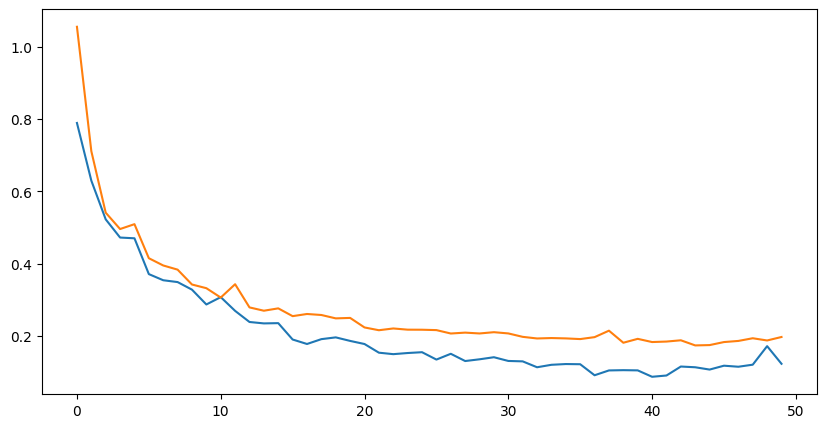

In [23]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list4)
plt.plot(val_losses)

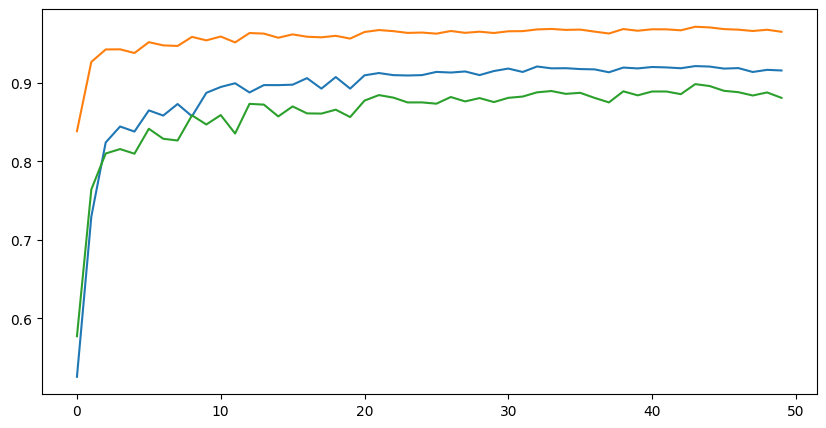

In [22]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list4)
plt.plot(val_accs)
plt.plot(val_mious)